In [20]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/dqn/#dqnpy
import os
import random
import time
from dataclasses import dataclass

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tyro
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter


@dataclass
class Args:
    exp_name: str = "baseline_dqn"
    """the name of this experiment"""
    seed: int = 1
    """seed of the experiment"""
    torch_deterministic: bool = True
    """if toggled, `torch.backends.cudnn.deterministic=False`"""
    cuda: bool = True
    """if toggled, cuda will be enabled by default"""
    track: bool = False
    """if toggled, this experiment will be tracked with Weights and Biases"""
    wandb_project_name: str = "cleanRL"
    """the wandb's project name"""
    wandb_entity: str = None
    """the entity (team) of wandb's project"""
    capture_video: bool = False
    """whether to capture videos of the agent performances (check out `videos` folder)"""
    save_model: bool = False
    """whether to save model into the `runs/{run_name}` folder"""
    upload_model: bool = False
    """whether to upload the saved model to huggingface"""
    hf_entity: str = ""
    """the user or org name of the model repository from the Hugging Face Hub"""

    # Algorithm specific arguments
    env_id: str = "CartPole-v1"
    """the id of the environment"""
    total_timesteps: int = 500000
    """total timesteps of the experiments"""
    learning_rate: float = 2.5e-4
    """the learning rate of the optimizer"""
    num_envs: int = 1
    """the number of parallel game environments"""
    buffer_size: int = 10000
    """the replay memory buffer size"""
    gamma: float = 0.99
    """the discount factor gamma"""
    tau: float = 1.0
    """the target network update rate"""
    target_network_frequency: int = 500
    """the timesteps it takes to update the target network"""
    batch_size: int = 128
    """the batch size of sample from the reply memory"""
    start_e: float = 1
    """the starting epsilon for exploration"""
    end_e: float = 0.05
    """the ending epsilon for exploration"""
    exploration_fraction: float = 0.5
    """the fraction of `total-timesteps` it takes from start-e to go end-e"""
    learning_starts: int = 10000
    """timestep to start learning"""
    train_frequency: int = 10
    """the frequency of training"""


def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env.action_space.seed(seed)

        return env

    return thunk


# ALGO LOGIC: initialize agent here:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(np.array(env.single_observation_space.shape).prod(), 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, env.single_action_space.n),
        )

    def forward(self, x):
        return self.network(x)


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

In [21]:
import stable_baselines3 as sb3

if sb3.__version__ < "2.0":
    raise ValueError(
        """Ongoing migration: run the following command to install the new dependencies:

poetry run pip install "stable_baselines3==2.0.0a1"
"""
    )

args = Args()

In [22]:
assert args.num_envs == 1, "vectorized envs are not supported at the moment"
run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=True,
        save_code=True,
    )
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.highlight to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.highlight` for environment variables or `env.get_wrapper_attr('highlight')` that will search the reminding wrappers.
  logger.warn(
/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.tile_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.tile_size` fo

ValueError: Cannot batch space with type `<class 'gymnasium.spaces.box.Box'>`. The space must be a valid `gym.Space` instance.

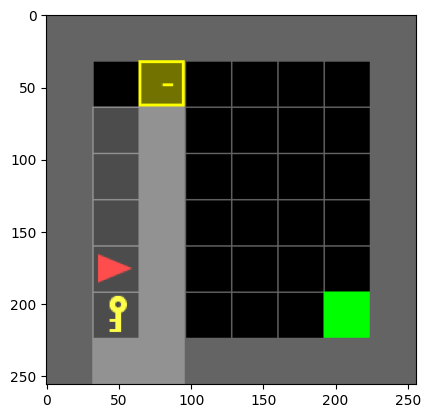

In [32]:
# env setup
envs = gym.vector.SyncVectorEnv(
    [make_env(8, args.seed)]
)
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

q_network = QNetwork(envs).to(device)
optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
target_network = QNetwork(envs).to(device)
target_network.load_state_dict(q_network.state_dict())

rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)
start_time = time.time()

In [31]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from minigrid.envs.doorkey import DoorKeyEnv
import pandas as pd
from gym.envs.registration import registry, register
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt
from minigrid.wrappers import ObservationWrapper


# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

class MyDoorKeyEnv(DoorKeyEnv):
    def __init__(self, size):
        self.render_mode = "rgb_array"
        super().__init__(size=size)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

class ImgObsWrapper(ObservationWrapper):
    """
    Use the image as the only observation output, no language/mission.

    Parameters:
    - env (gym.Env): The environment to wrap.

    Methods:
    - observation(self, obs): Returns the image from the observation.
    - reset(self): Resets the environment and returns the initial observation.
    """

    def __init__(self, env):
        """
        Initializes the ImgObsWrapper with the given environment.

        Parameters:
        - env (gym.Env): The environment whose observations are to be wrapped.
        """
        super().__init__(env)
        self.observation_space = env.observation_space.spaces["image"]

    def observation(self, obs):
        """
        Extracts and returns the image data from the observation.

        Parameters:
        - obs (dict or tuple): The original observation from the environment, which could be either
        a dictionary or a tuple containing a dictionary.

        Returns:
        - np.ndarray: The image data extracted from the observation.
        """
        if type(obs) == tuple:
            return obs[0]["image"]
        return obs["image"]

    def reset(self):
        """
        Resets the environment and returns the initial observation image.

        Returns:
        - np.ndarray: The initial observation image of the reset environment.
        """
        obs = super().reset()
        return obs[0]
    
def get_door_key_env(size):
    """
    Returns a DoorKeyEnv environment with the given size.
    """
    env = MyDoorKeyEnv(size=size)
    env = ImgObsWrapper(env)

    env.reset()
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)

    # get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
    #            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
    #            tile_size (int): How many pixels will form a tile from the NxM grid.
    #            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
    frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
    # show an image to the notebook.
    plt.imshow(frame)

    return env


def make_env(size, seed):
    def thunk():
        env = get_door_key_env(size)
        env.action_space.seed(seed)

        return env

    return thunk

In [24]:
# TRY NOT TO MODIFY: start the game
obs, _ = envs.reset(seed=args.seed)
for global_step in range(args.total_timesteps):
    # ALGO LOGIC: put action logic here
    epsilon = linear_schedule(args.start_e, args.end_e, args.exploration_fraction * args.total_timesteps, global_step)
    if random.random() < epsilon:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        q_values = q_network(torch.Tensor(obs).to(device))
        actions = torch.argmax(q_values, dim=1).cpu().numpy()

    # TRY NOT TO MODIFY: execute the game and log data.
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    if "final_info" in infos:
        for info in infos["final_info"]:
            if info and "episode" in info:
                print(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)

    # TRY NOT TO MODIFY: save data to reply buffer; handle `final_observation`
    real_next_obs = next_obs.copy()
    for idx, trunc in enumerate(truncations):
        if trunc:
            real_next_obs[idx] = infos["final_observation"][idx]
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # TRY NOT TO MODIFY: CRUCIAL step easy to overlook
    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        if global_step % args.train_frequency == 0:
            data = rb.sample(args.batch_size)
            with torch.no_grad():
                target_max, _ = target_network(data.next_observations).max(dim=1)
                td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())
            old_val = q_network(data.observations).gather(1, data.actions).squeeze()
            loss = F.mse_loss(td_target, old_val)

            if global_step % 100 == 0:
                writer.add_scalar("losses/td_loss", loss, global_step)
                writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                print("SPS:", int(global_step / (time.time() - start_time)))
                writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

            # optimize the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # update target network
        if global_step % args.target_network_frequency == 0:
            for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                target_network_param.data.copy_(
                    args.tau * q_network_param.data + (1.0 - args.tau) * target_network_param.data
                )

if args.save_model:
    model_path = f"runs/{run_name}/{args.exp_name}.cleanrl_model"
    torch.save(q_network.state_dict(), model_path)
    print(f"model saved to {model_path}")
    from cleanrl_utils.evals.dqn_eval import evaluate

    episodic_returns = evaluate(
        model_path,
        make_env,
        args.env_id,
        eval_episodes=10,
        run_name=f"{run_name}-eval",
        Model=QNetwork,
        device=device,
        epsilon=0.05,
    )
    for idx, episodic_return in enumerate(episodic_returns):
        writer.add_scalar("eval/episodic_return", episodic_return, idx)

    if args.upload_model:
        from cleanrl_utils.huggingface import push_to_hub

        repo_name = f"{args.env_id}-{args.exp_name}-seed{args.seed}"
        repo_id = f"{args.hf_entity}/{repo_name}" if args.hf_entity else repo_name
        push_to_hub(args, episodic_returns, repo_id, "DQN", f"runs/{run_name}", f"videos/{run_name}-eval")

envs.close()
writer.close()

global_step=28, episodic_return=[29.]
global_step=38, episodic_return=[10.]
global_step=49, episodic_return=[11.]
global_step=85, episodic_return=[36.]
global_step=98, episodic_return=[13.]
global_step=114, episodic_return=[16.]
global_step=131, episodic_return=[17.]
global_step=150, episodic_return=[19.]
global_step=187, episodic_return=[37.]
global_step=214, episodic_return=[27.]
global_step=229, episodic_return=[15.]
global_step=242, episodic_return=[13.]
global_step=265, episodic_return=[23.]
global_step=275, episodic_return=[10.]
global_step=304, episodic_return=[29.]
global_step=322, episodic_return=[18.]
global_step=333, episodic_return=[11.]
global_step=344, episodic_return=[11.]
global_step=390, episodic_return=[46.]
global_step=401, episodic_return=[11.]
global_step=433, episodic_return=[32.]
global_step=480, episodic_return=[47.]
global_step=496, episodic_return=[16.]
global_step=522, episodic_return=[26.]
global_step=556, episodic_return=[34.]
global_step=572, episodic_retu

KeyboardInterrupt: 